In [1]:
!pip install torch-scatter --quiet
!pip install torch-sparse --quiet
!pip install torch-geometric --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.4 MB/s eta 0:00:00


In [2]:
import networkx as nx
import numpy as np
import math
import matplotlib.pyplot as plt

import torch
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, global_add_pool
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import random_split

In [3]:
dset = QM9('.')
len(dset)

Extracting ./raw/qm9_v3.zip
Processing...
Using a pre-processed version of the dataset. Please install 'rdkit' to alternatively process the raw data.
Done!


130831

In [4]:
data = dset[0]
data

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5])

In [5]:
data.z

tensor([6, 1, 1, 1, 1])

In [6]:
data.new_attribute = torch.tensor([1, 2, 3])
data

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5], new_attribute=[3])

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data.to(device)

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5], new_attribute=[3])

In [8]:
train_set, valid_set, test_set = random_split(dset, [110000, 10831, 10000])
trainloader = DataLoader(train_set, batch_size=32, shuffle=True)
validloader = DataLoader(valid_set, batch_size=32, shuffle=True)
testloader = DataLoader(test_set, batch_size=32, shuffle=True)

In [9]:
class ExampleNet(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features):
        super().__init__()
        conv1_net = nn.Sequential(nn.Linear(num_edge_features, 32),
                                  nn.ReLU(),
                                  nn.Linear(32, num_node_features * 32))
        conv2_net = nn.Sequential(nn.Linear(num_edge_features, 32),
                                  nn.ReLU(),
                                  nn.Linear(32, 32 * 16))
        self.conv1 = NNConv(num_node_features, 32, conv1_net)
        self.conv2 = NNConv(32, 16, conv2_net)
        self.fc_1 = nn.Linear(16, 32)
        self.out = nn.Linear(32, 1)

    def forward(self, data):
        batch, x, edge_index, edge_attr = data.batch, data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = global_add_pool(x, batch)
        x = F.relu(self.fc_1(x))
        output = self.out(x)
        return output

In [10]:
qm9_node_feats, qm9_edge_feats = 11, 4
net = ExampleNet(qm9_node_feats, qm9_edge_feats)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
epochs = 4
target_idx = 1

net.to(device)

ExampleNet(
  (conv1): NNConv(11, 32, aggr=add, nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=352, bias=True)
  ))
  (conv2): NNConv(32, 16, aggr=add, nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=512, bias=True)
  ))
  (fc_1): Linear(in_features=16, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)

In [11]:
for total_epochs in range(epochs):
    epoch_loss = 0
    total_graphs = 0
    net.train()
    for batch in trainloader:
        batch.to(device)
        optimizer.zero_grad()
        output = net(batch)
        loss = F.mse_loss(output, batch.y[:, target_idx]. unsqueeze(1))
        loss.backward()
        epoch_loss += loss.item()
        total_graphs += batch.num_graphs
        optimizer.step()

    train_avg_loss = epoch_loss / total_graphs
    val_loss = 0
    total_graphs = 0
    net.eval()
    for batch in validloader:
        batch.to(device)
        output = net(batch)
        loss = F.mse_loss(output, batch.y[:, target_idx].unsqueeze(1))
        val_loss += loss.item()
        total_graphs += batch.num_graphs

    val_avg_loss = val_loss / total_graphs
    print(f'Epochs: {total_epochs} | epoch avg. loss: {train_avg_loss} | validation avg. loss: {val_avg_loss}')

Epochs: 0 | epoch avg. loss: 0.5553130788526752 | validation avg. loss: 0.1257010282060026
Epochs: 1 | epoch avg. loss: 0.1547463054884564 | validation avg. loss: 0.1243125111230599
Epochs: 2 | epoch avg. loss: 0.11679071836525744 | validation avg. loss: 0.21173257566248982
Epochs: 3 | epoch avg. loss: 0.1005592918260531 | validation avg. loss: 0.05793962218558708


In [12]:
net.eval()
predictions = []
real = []
for batch in testloader:
    output = net(batch.to(device))
    predictions.append(output.detach().cpu().numpy())
    real.append(batch.y[:, target_idx].detach().cpu().numpy())

real = np.concatenate(real)
predictions = np.concatenate(predictions)

Text(0, 0.5, 'Predicted isotropic polarizability')

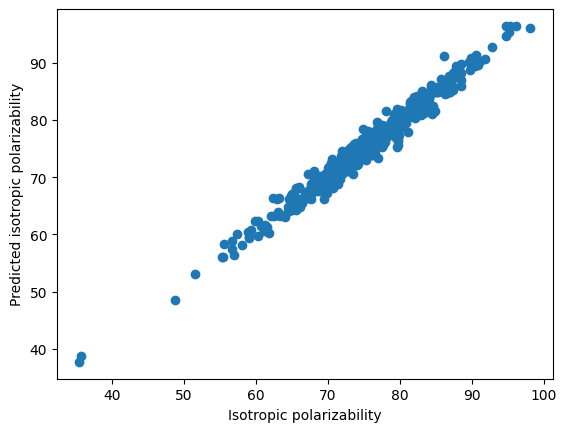

In [13]:
plt.scatter(real[:500], predictions[:500])
plt.xlabel('Isotropic polarizability')
plt.ylabel('Predicted isotropic polarizability')